# Organ comparison DGE list
# 20 Oct 2021 Chenqu

In [6]:
import numpy as np
import scipy as sp
import scanpy as sc
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
import seaborn as sb
from itertools import compress
import random
import joblib as jl
import matplotlib.patches as mpatches

sc.settings.set_figure_params(dpi = 160, color_map = 'RdYlBu_r', dpi_save = 300, format = 'pdf')
plt.rcParams["figure.figsize"] = [6,6]
#plt.rcParams['font.sans-serif']=['Arial']
#rc('font', **{'family':'sans-serif', 'sans-serif':['Arial']})
#plt.rcParams['pdf.fonttype'] = 'truetype'

In [7]:
sb.set_palette('tab10')

In [8]:
# # import utils
# import sys
# sys.path.append('/home/jovyan/chenqu_utils')
# from array_operations import *
# sys.path.append('/home/jovyan/thymusatlas/')
# import scjp
# from scjp import model

In [9]:
organ_order = ['YS','LI','BM','TH','SP','MLN','SK','GU','KI']

In [10]:
# # set working directory
# %cd /home/jovyan/panfetal/

In [11]:
# DGE path
DGE_path = '/nfs/team205/ed6/data/Fetal_immune/LMM_data/DE_input_HSC_IMMUNE_PBULK/'

In [12]:
# figure directory
fig_path = '/home/jovyan/mount/gdrive/Pan_fetal/plots_output/chenqu_jhub/'
sc.settings.figdir = fig_path

dependencies for enrichr and plotting

In [13]:
%matplotlib inline
%config InlineBackend.figure_format='retina' # mac
%load_ext autoreload
%autoreload 2
import gseapy as gp
from gseapy.plot import barplot, dotplot

In [14]:
gp.__version__

'0.10.5'

In [15]:
names = gp.get_library_name() # default: Human

In [16]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [17]:
%load_ext rpy2.ipython


In [18]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

# Load data

In [10]:
adata = sc.read('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.20210429.HSC_IMMUNE.embedding.annotated.h5ad')

Only considering the two last: ['.annotated', '.h5ad'].
Only considering the two last: ['.annotated', '.h5ad'].


In [11]:
adata.raw = adata.copy()

In [12]:
obs = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv', index_col = 0) 
# final annotations and removed maternal contaminant cells, all the cells

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
for col in obs:
    adata.obs[col]=obs[col]

In [14]:
adata.obs['donor_organ']=np.char.array(adata.obs['donor'],unicode=True)+'_'+np.char.array(adata.obs['organ'],unicode=True)

# TH vs other organ T cells

## GSEA plot for significant DGEs

In [20]:
## Make directory for outputs
import os
os.mkdir('csv/')

In [16]:
### load DGE results
dge = pd.read_csv(DGE_path+'DE_results_TH_vs_rest_TEST_CD4+T-CD8+T-TREG-NK_T-TH17_CTRL_MACROPHAGE_I-NK-MID_ERY.csv')
test = ["CD4+T","CD8+T","TREG","NK_T","TH17"]
ctrl = ["MACROPHAGE_I","NK"]

In [17]:
# find background set of genes 
background = list(set(dge['name']))

In [21]:
# for positively enriched list
# find genes that adjusted pval < 0.1, lfc > 1 for at least 3 test cell types
# but not within the significant list (adjusted pval < 0.1, lfc > 0) in control cell type
dge_sig = dge[np.array(dge['adj_pval']<0.1) & np.array(dge['lfc'] > 0)]
dge_sig_test = dge_sig[np.array(dge_sig['test_celltype'].isin(test)) & np.array(dge_sig['lfc'] > 1)]
tbl = pd.DataFrame.from_dict(Counter(dge_sig_test['name']), orient='index').reset_index()

dge_sig_ctl = dge_sig[dge_sig['test_celltype'].isin(ctrl)]
tbl_new = tbl[~(tbl['index'].isin(dge_sig_ctl['name']))]

df = tbl_new.loc[tbl_new[0]>2,]
df['lfc_mean'] = 0
for i in range(df.shape[0]):
    gene = df.iloc[i,0]
    df.iloc[i,2] = np.mean(dge_sig_test.loc[dge_sig_test['name']==gene,'lfc'])
df.to_csv('csv/DE_results_THtcells_THvsOther_compiled_poslfc.csv')

# for negatively enriched list
# find genes that adjusted pval < 0.1, lfc < -1 for at least 3 test cell types
# but not within the significant list (adjusted pval < 0.1, lfc > 0) in control cell type
dge_sig = dge[np.array(dge['adj_pval']<0.1) & np.array(dge['lfc'] < 0)]
dge_sig_test = dge_sig[np.array(dge_sig['test_celltype'].isin(test)) & np.array(dge_sig['lfc'] < -1)]
tbl = pd.DataFrame.from_dict(Counter(dge_sig_test['name']), orient='index').reset_index()

dge_sig_ctl = dge_sig[dge_sig['test_celltype'].isin(ctrl)]
tbl_new = tbl[~(tbl['index'].isin(dge_sig_ctl['name']))]

df = tbl_new.loc[tbl_new[0]>2,]
df['lfc_mean'] = 0
for i in range(df.shape[0]):
    gene = df.iloc[i,0]
    df.iloc[i,2] = np.mean(dge_sig_test.loc[dge_sig_test['name']==gene,'lfc'])
df.to_csv('csv/DE_results_THtcells_THvsOther_compiled_neglfc.csv')

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [109]:
df = pd.read_csv('csv/DE_results_THtcells_THvsOther_compiled_neglfc.csv')
gene_list = list(df['index'])

In [110]:
gene_sets=['MSigDB_Hallmark_2020']

In [111]:
# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_sets,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 background = background,
                 description='test_name',
                 outdir='csv/enrichr/',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [112]:
# obj.results stores all results
enr.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,IL-2/STAT5 Signaling,7/199,0.000082,0.001223,0,0,7.405928,69.707145,SOCS2;GABARAPL1;AHNAK;CISH;PTGER2;IL18R1;SERPINB6
1,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,7/200,0.000084,0.001223,0,0,7.367181,69.111138,NR4A2;SOCS3;PLEK;FOSB;SIK1;JUNB;KLF2
2,MSigDB_Hallmark_2020,Apoptosis,5/161,0.001539,0.014877,0,0,6.390831,41.391066,ANXA1;LMNA;FAS;TSPO;CDC25B
3,MSigDB_Hallmark_2020,Interferon Gamma Response,5/200,0.003932,0.019006,0,0,5.102564,28.260755,SOCS3;FAS;UPP1;SAMHD1;HLA-DRB1
4,MSigDB_Hallmark_2020,Complement,5/200,0.003932,0.019006,0,0,5.102564,28.260755,FCER1G;ITGAM;PLEK;S100A9;CD55


In [113]:
# to save your figure, make sure that ``ofname`` is not None
ax=dotplot(enr.res2d, title='MSigDB_Hallmark_2020',cmap='RdYlBu_r',cutoff=1, top_terms=10,figsize=(6,6),ofname=fig_path+'THvsothersTcells_neglfc_enrichr.pdf')

## Plot significant DGEs in organ comparison 

In [114]:
genes = enr.results.iloc[1,9].split(';') 
cts = ['CD4+T','CD8+T','TREG','TYPE_3_INNATE_T','TYPE_1_INNATE_T']

KeyboardInterrupt: 

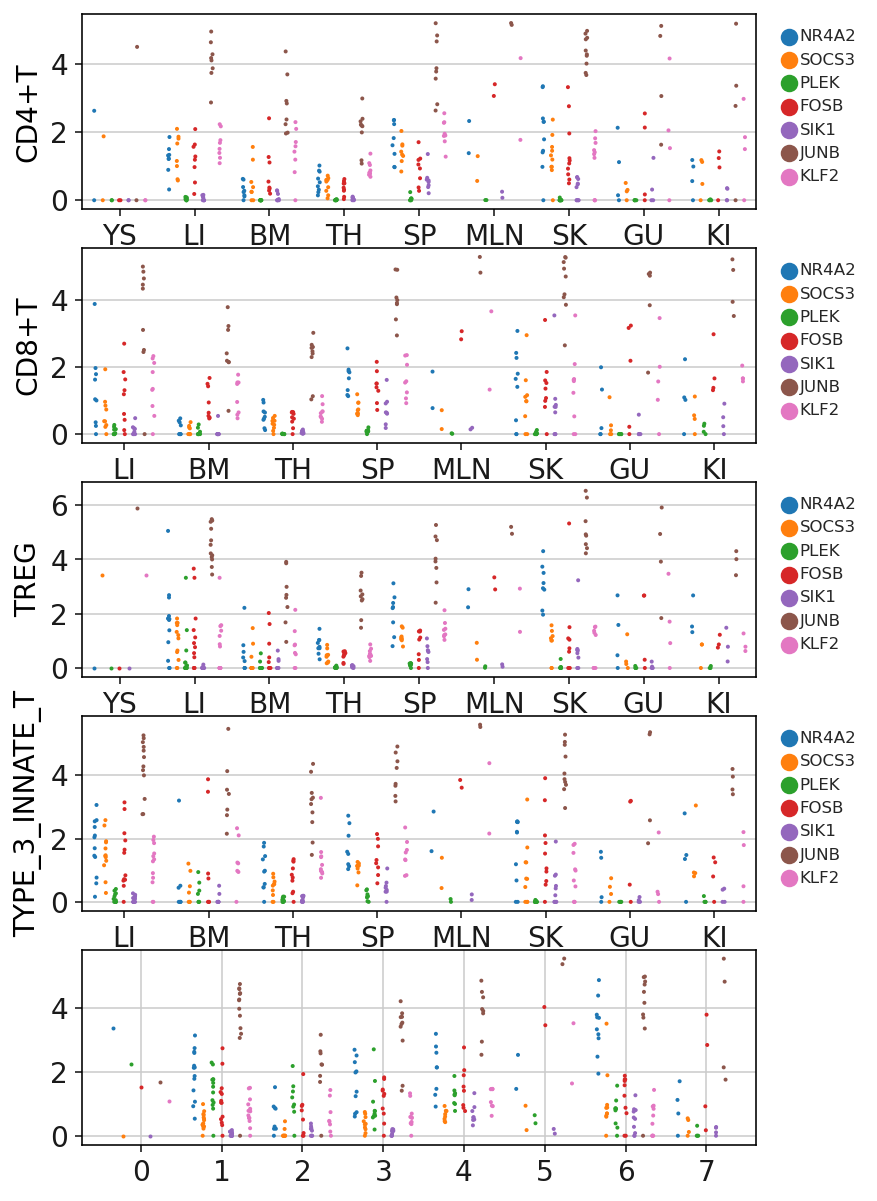

In [29]:
fig, ax = plt.subplots(5,1,figsize=(6,10))
for j in range(5):
    ct = cts[j]
    ct_data = adata[adata.obs['anno_lvl_2_final_clean']==ct]
    
    donor_organ_list = set(ct_data.obs['donor_organ'])
    df = pd.DataFrame(index = range(len(donor_organ_list) * len(genes)), columns = ['donor_organ','donor','organ','expression','gene'])
    df['donor_organ']=list(donor_organ_list)*len(genes)
    df['genes']=np.repeat(np.array(genes),len(donor_organ_list))
    
    for i in df.index: 
        donor_organ = df['donor_organ'][i]
        data_select = ct_data[ct_data.obs['donor_organ']==donor_organ]
        gene = df['genes'][i]
        df.iloc[i,3]=np.mean(data_select[:,gene].X)
    
    df['donor']=[name.split('_')[0] for name in df['donor_organ']]
    df['organ']=[name.split('_')[1] for name in df['donor_organ']]
    
    df['organ']=df['organ'].astype('category')
    df['organ']=df['organ'].cat.reorder_categories([organ for organ in organ_order if organ in set(df['organ'])])
    
    #plt.rcParams["figure.figsize"] = [8,8]
    sb.set_theme(style='ticks')
    s = sb.stripplot(x="organ", y="expression",hue='genes',data=df, palette="tab10",dodge=True,size=2,ax=ax[j])
    s.set(ylabel=ct)
    s.set(xlabel='')
    #ax[j].set_ylim([0, 1])
    ax[j].legend(loc='upper left',bbox_to_anchor=(1.02, 1),frameon=False, fontsize='x-small')

# plt.savefig(fig_path+'DE_results_THtcells_THvsOther_compiled_neglfc.pdf',bbox_inches='tight')

dotplot

In [115]:
df4 = pd.DataFrame(index = range(11), columns=['organ','ct']+genes)
df4['organ']=['TH']*6+['others']*5
df4['ct']=['ABT(ENTRY)']+['CD4+T','CD8+T','TREG','TYPE_3_INNATE_T','TYPE_1_INNATE_T']*2

for i in df4.index:
    ct = df4['ct'][i]
    
    if df4['organ'][i]=='TH':
        a = np.array(adata.obs['organ'].isin(['TH']))
        b = np.array(adata.obs['anno_lvl_2_final_clean']==ct)
        data_select=adata[list(a&b)]
        
        for gene in genes:
            df4[gene][i] = np.mean(data_select[:,gene].X)
    else:
        a = np.array(~(adata.obs['organ'].isin(['TH'])))
        b = np.array(adata.obs['anno_lvl_2_final_clean']==ct)
        data_select=adata[list(a&b)]
        
        for gene in genes:
            df4[gene][i] = np.mean(data_select[:,gene].X)

df5 = df4.iloc[:,2:].astype('float')
df5.index=df4['organ']+'_'+df4['ct']

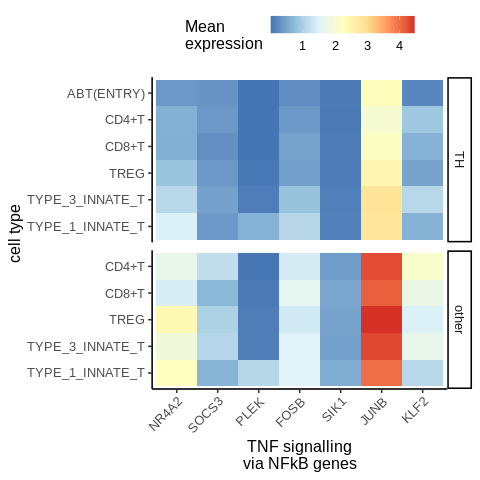

In [116]:
%%R -i df5 -i genes -i fig_path
gene_set_name = "TNF signalling\nvia NFkB genes"
ct_order=c("ABT(ENTRY)", 'CD4+T','CD8+T','TREG','TYPE_3_INNATE_T','TYPE_1_INNATE_T')

pl <- rownames_to_column(df5) %>%
        pivot_longer(cols=-rowname, names_to="gene", values_to="expression") %>%
        mutate(organ=ifelse(str_detect(rowname, '^TH'), "TH", "other"),
               celltype=str_remove(rowname, 'TH_|others_')
              ) %>%
        mutate(organ=factor(organ, levels=c("TH", "other"))) %>%
        mutate(gene=factor(gene, levels=genes)) %>%
        mutate(celltype=factor(celltype, levels=rev(ct_order))) %>%
        ggplot(aes(gene, celltype, fill=expression)) +
        geom_tile() +
        facet_grid(organ~., space="free", scales="free") +
        scale_fill_distiller(palette='RdYlBu', name='Mean\nexpression') +
        guides(fill=guide_colorbar(barwidth = 10)) +
        ylab("cell type") + 
        xlab(gene_set_name) +
        theme_classic(base_size=16) +
        theme(axis.text.x=element_text(angle=45, hjust=1),
             legend.position='top') 
pl + ggsave(paste0(fig_path, 'THvsothersTcells_neglfc_heatmap.clean.pdf'), width=6, height=5) 

In [69]:
# fig, ax = plt.subplots(figsize=(df5.shape[1]/2,df5.shape[0]/2))
# sb.heatmap(df5,cmap='RdYlBu_r')
# plt.savefig(fig_path+'THvsothersTcells_neglfc_heatmap.pdf',bbox_inches='tight');

In [98]:
df = pd.read_csv('csv/DE_results_THtcells_THvsOther_compiled_poslfc.csv')
gene_list = list(df['index'])

In [99]:
gene_sets=['MSigDB_Hallmark_2020']

In [100]:
# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_sets,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 background = background,
                 description='test_name',
                 outdir='csv/enrichr/',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [101]:
# obj.results stores all results
enr.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Interferon Alpha Response,7/97,0.000002,0.000038,0,0,13.267146,172.379138,LGALS3BP;PLSCR1;LAMP3;CMPK2;DDX60;PARP9;IFIT3
1,MSigDB_Hallmark_2020,Hypoxia,9/200,0.000004,0.000038,0,0,8.136952,100.907314,LDHA;P4HA1;RRAGD;AK4;ALDOC;ENO2;HK2;PDK1;VEGFA
2,MSigDB_Hallmark_2020,mTORC1 Signaling,9/200,0.000004,0.000038,0,0,8.136952,100.907314,MLLT11;LDHA;P4HA1;SORD;AK4;BCAT1;HK2;PDK1;MCM2
3,MSigDB_Hallmark_2020,Glycolysis,9/200,0.000004,0.000038,0,0,8.136952,100.907314,LDHA;PKM;P4HA1;PGAM1;RRAGD;AK4;ENO2;HK2;VEGFA
4,MSigDB_Hallmark_2020,Interferon Gamma Response,7/200,0.000240,0.001779,0,0,6.154547,51.287895,LGALS3BP;PLSCR1;OAS3;CMPK2;IFIT1;DDX60;IFIT3


## Plot significant DGEs in organ comparison 

In [103]:
genes = enr.results.iloc[0,9].split(';') 
cts = ['CD4+T','CD8+T','TREG','TYPE_3_INNATE_T','TYPE_1_INNATE_T']

In [104]:
# fig, ax = plt.subplots(5,1,figsize=(6,10))
# for j in range(5):
#     ct = cts[j]
#     ct_data = adata[adata.obs['anno_lvl_2_final_clean']==ct]
    
#     donor_organ_list = set(ct_data.obs['donor_organ'])
#     df = pd.DataFrame(index = range(len(donor_organ_list) * len(genes)), columns = ['donor_organ','donor','organ','expression','gene'])
#     df['donor_organ']=list(donor_organ_list)*len(genes)
#     df['genes']=np.repeat(np.array(genes),len(donor_organ_list))
    
#     for i in df.index: 
#         donor_organ = df['donor_organ'][i]
#         data_select = ct_data[ct_data.obs['donor_organ']==donor_organ]
#         gene = df['genes'][i]
#         df.iloc[i,3]=np.mean(data_select[:,gene].X)
    
#     df['donor']=[name.split('_')[0] for name in df['donor_organ']]
#     df['organ']=[name.split('_')[1] for name in df['donor_organ']]
    
#     df['organ']=df['organ'].astype('category')
#     df['organ']=df['organ'].cat.reorder_categories([organ for organ in organ_order if organ in set(df['organ'])])
    
#     #plt.rcParams["figure.figsize"] = [8,8]
#     sb.set_theme(style='ticks')
#     s = sb.stripplot(x="organ", y="expression",hue='genes',data=df, palette="tab10",dodge=True,size=2,ax=ax[j])
#     s.set(ylabel=ct)
#     s.set(xlabel='')
#     #ax[j].set_ylim([0, 1])
#     ax[j].legend(loc='upper left',bbox_to_anchor=(1.02, 1),frameon=False, fontsize='x-small')

# # plt.savefig(fig_path+'DE_results_THtcells_THvsOther_compiled_neglfc.pdf',bbox_inches='tight')

dotplot

In [105]:
df4 = pd.DataFrame(index = range(11), columns=['organ','ct']+genes)
df4['organ']=['TH']*6+['others']*5
df4['ct']=['ABT(ENTRY)']+['CD4+T','CD8+T','TREG','TYPE_3_INNATE_T','TYPE_1_INNATE_T']*2

for i in df4.index:
    ct = df4['ct'][i]
    
    if df4['organ'][i]=='TH':
        a = np.array(adata.obs['organ'].isin(['TH']))
        b = np.array(adata.obs['anno_lvl_2_final_clean']==ct)
        data_select=adata[list(a&b)]
        
        for gene in genes:
            df4[gene][i] = np.mean(data_select[:,gene].X)
    else:
        a = np.array(~(adata.obs['organ'].isin(['TH'])))
        b = np.array(adata.obs['anno_lvl_2_final_clean']==ct)
        data_select=adata[list(a&b)]
        
        for gene in genes:
            df4[gene][i] = np.mean(data_select[:,gene].X)

df5 = df4.iloc[:,2:].astype('float')
df5.index=df4['organ']+'_'+df4['ct']

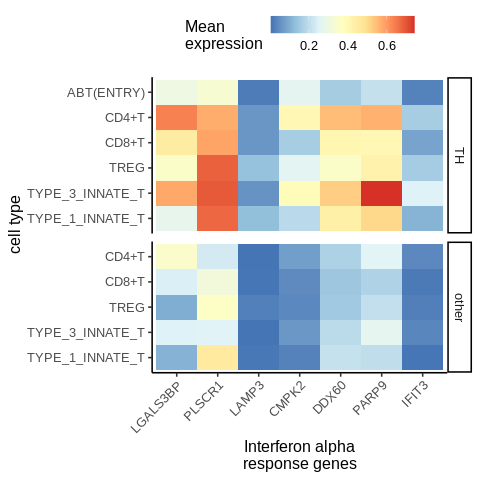

In [107]:
%%R -i df5 -i genes -i fig_path
gene_set_name = "Interferon alpha\nresponse genes"
ct_order=c("ABT(ENTRY)", 'CD4+T','CD8+T','TREG','TYPE_3_INNATE_T','TYPE_1_INNATE_T')

pl2 <- rownames_to_column(df5) %>%
        pivot_longer(cols=-rowname, names_to="gene", values_to="expression") %>%
        mutate(organ=ifelse(str_detect(rowname, '^TH'), "TH", "other"),
               celltype=str_remove(rowname, 'TH_|others_')
              ) %>%
        mutate(organ=factor(organ, levels=c("TH", "other"))) %>%
        mutate(gene=factor(gene, levels=genes)) %>%
        mutate(celltype=factor(celltype, levels=rev(ct_order))) %>%
        ggplot(aes(gene, celltype, fill=expression)) +
        geom_tile() +
        facet_grid(organ~., space="free", scales="free") +
        scale_fill_distiller(palette='RdYlBu', name='Mean\nexpression') +
        guides(fill=guide_colorbar(barwidth = 10)) +
        ylab("cell type") + 
        xlab(gene_set_name) +
        theme_classic(base_size=16) +
        theme(axis.text.x=element_text(angle=45, hjust=1),
             legend.position='top') 
        
pl2 + ggsave(paste0(fig_path, 'THvsothersTcells_poslfc_heatmap.clean.pdf'), width=6, height=5) 

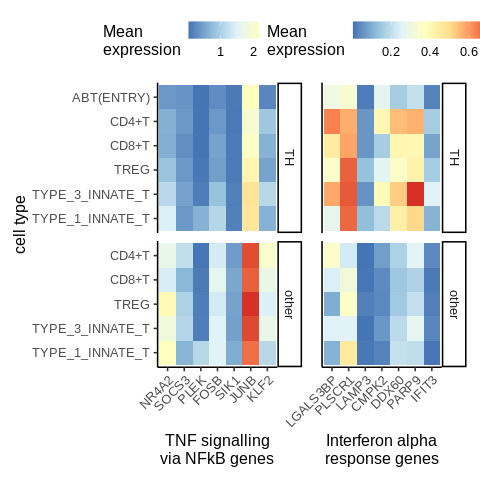

In [119]:
%%R
(pl | (pl2 + remove_y_axis())) +
    ggsave('~/mount/gdrive/Pan_fetal/writing/ms_figures/draft_panels/Fig2_myeloid_lymphoid/assemble_fig2/THvsothersTcells_heatmap.clean.pdf', 
           width=12, height=5) 

# TH vs other organ B1

## GSEA plot for significant DGEs

In [87]:
### load DGE results
dge = pd.read_csv(DGE_path+'DE_results_TH_vs_rest_TEST_B1_CTRL_CD4+T-NK-MID_ERY.csv')
test = ["B1"]
ctrl = ["CD4+T","NK"]

In [88]:
# find background set of genes 
background = list(set(dge['name']))

In [89]:
# for positively enriched list
# find genes that adjusted pval < 0.1, lfc > 1 for at least 3 test cell types
# but not within the significant list (adjusted pval < 0.1, lfc > 0) in control cell type
dge_sig = dge[np.array(dge['adj_pval']<0.1) & np.array(dge['lfc'] > 0)]
dge_sig_test = dge_sig[np.array(dge_sig['test_celltype'].isin(test)) & np.array(dge_sig['lfc'] > 1)]
tbl = pd.DataFrame.from_dict(Counter(dge_sig_test['name']), orient='index').reset_index()

dge_sig_ctl = dge_sig[dge_sig['test_celltype'].isin(ctrl)]
tbl_new = tbl[~(tbl['index'].isin(dge_sig_ctl['name']))]

df = tbl_new
df['lfc_mean'] = 0
for i in range(df.shape[0]):
    gene = df.iloc[i,0]
    df.iloc[i,2] = np.mean(dge_sig_test.loc[dge_sig_test['name']==gene,'lfc'])
df.to_csv('csv/DE_results_THB1_THvsOther_compiled_poslfc.csv')

# for negatively enriched list
# find genes that adjusted pval < 0.1, lfc < -1 for at least 3 test cell types
# but not within the significant list (adjusted pval < 0.1, lfc > 0) in control cell type
dge_sig = dge[np.array(dge['adj_pval']<0.1) & np.array(dge['lfc'] < 0)]
dge_sig_test = dge_sig[np.array(dge_sig['test_celltype'].isin(test)) & np.array(dge_sig['lfc'] < -1)]
tbl = pd.DataFrame.from_dict(Counter(dge_sig_test['name']), orient='index').reset_index()

dge_sig_ctl = dge_sig[dge_sig['test_celltype'].isin(ctrl)]
tbl_new = tbl[~(tbl['index'].isin(dge_sig_ctl['name']))]

df = tbl_new
df['lfc_mean'] = 0
for i in range(df.shape[0]):
    gene = df.iloc[i,0]
    df.iloc[i,2] = np.mean(dge_sig_test.loc[dge_sig_test['name']==gene,'lfc'])
df.to_csv('csv/DE_results_THB1_THvsOther_compiled_neglfc.csv')

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [90]:
df = pd.read_csv('csv/DE_results_THB1_THvsOther_compiled_neglfc.csv')
gene_list = list(df['index'])

In [91]:
gene_sets=['MSigDB_Hallmark_2020']

In [92]:
# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_sets,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 background = background,
                 description='test_name',
                 outdir='csv/enrichr/',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [93]:
# obj.results stores all results
enr.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,IL-2/STAT5 Signaling,6/199,0.000334,0.010701,0,0,7.044488,56.378213,CCND2;AHCY;CA2;MAPKAPK2;ODC1;ITGAE
1,MSigDB_Hallmark_2020,Fatty Acid Metabolism,5/158,0.000858,0.013727,0,0,7.335859,51.798316,ALDH3A2;CA2;ODC1;CD1D;CRYZ
2,MSigDB_Hallmark_2020,mTORC1 Signaling,4/200,0.014197,0.113575,0,0,4.519835,19.230709,PSMA3;SDF2L1;TOMM40;ATP5MC1
3,MSigDB_Hallmark_2020,Xenobiotic Metabolism,4/200,0.014197,0.113575,0,0,4.519835,19.230709,AHCY;CA2;ABHD6;MAN1A1
4,MSigDB_Hallmark_2020,Apoptosis,3/161,0.039269,0.236580,0,0,4.166456,13.488100,CCND2;PDCD4;CD38


In [112]:
# to save your figure, make sure that ``ofname`` is not None
ax=dotplot(enr.res2d, title='MSigDB_Hallmark_2020',cmap='RdYlBu_r',cutoff=1, top_terms=10,figsize=(6,6),ofname=fig_path+'THvsothersB1_neglfc_enrichr.pdf')

## Plot significant DGEs in organ comparison 

In [94]:
genes = enr.results.iloc[0,9].split(';') 

In [95]:
ct_data = adata[adata.obs['anno_lvl_2_final_clean']=='B1']

In [96]:
donor_organ_list = set(ct_data.obs['donor_organ'])
df = pd.DataFrame(index = range(len(donor_organ_list) * len(genes)), columns = ['donor_organ','donor','organ','expression','gene'])
df['donor_organ']=list(donor_organ_list)*len(genes)
df['genes']=np.repeat(np.array(genes),len(donor_organ_list))
for i in df.index: 
    donor_organ = df['donor_organ'][i]
    data_select = ct_data[ct_data.obs['donor_organ']==donor_organ]
    gene = df['genes'][i]
    df.iloc[i,3]=np.mean(data_select[:,gene].X)
df['donor']=[name.split('_')[0] for name in df['donor_organ']]
df['organ']=[name.split('_')[1] for name in df['donor_organ']]
df['organ']=df['organ'].astype('category')
df['organ']=df['organ'].cat.reorder_categories([organ for organ in organ_order if organ in set(df['organ'])])

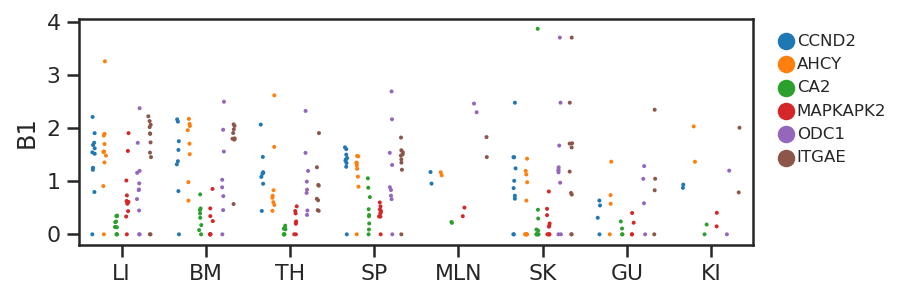

In [116]:
#plt.rcParams["figure.figsize"] = [8,8]
sb.set_theme(style='ticks')
fig, ax = plt.subplots(figsize=(6,2))
s = sb.stripplot(x="organ", y="expression",hue='genes',data=df, palette="tab10",dodge=True,size=2)
s.set(ylabel='B1')
s.set(xlabel='')
ax.legend(loc='upper left',bbox_to_anchor=(1.02, 1),frameon=False, fontsize='x-small')
#plt.savefig('figures/MONOCYTE_III_CCR2.pdf',bbox_inches='tight')

dotplot

In [97]:
df4 = pd.DataFrame(index = range(2), columns=['organ','ct']+genes)
df4['organ']=['TH','others']
df4['ct']=['B1']*2
for i in df4.index:
    ct = df4['ct'][i]
    
    if df4['organ'][i]=='TH':
        a = np.array(adata.obs['organ'].isin(['TH']))
        b = np.array(adata.obs['anno_lvl_2_final_clean']==ct)
        data_select=adata[list(a&b)]
        
        for gene in genes:
            df4[gene][i] = np.mean(data_select[:,gene].X)
    else:
        a = np.array(~(adata.obs['organ'].isin(['TH'])))
        b = np.array(adata.obs['anno_lvl_2_final_clean']==ct)
        data_select=adata[list(a&b)]
        
        for gene in genes:
            df4[gene][i] = np.mean(data_select[:,gene].X)
df5 = df4.iloc[:,2:].astype('float')
df5.index=df4['organ']+'_'+df4['ct']

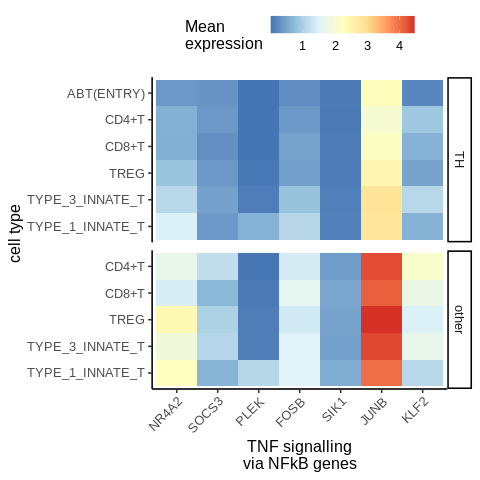

In [86]:
# %%R -i df5 -i genes -i fig_path
# gene_set_name = "Interferon alpha\nresponse genes"
# ct_order=c("ABT(ENTRY)", 'CD4+T','CD8+T','TREG','TYPE_3_INNATE_T','TYPE_1_INNATE_T')

# pl <- rownames_to_column(df5) %>%
#         pivot_longer(cols=-rowname, names_to="gene", values_to="expression") %>%
#         mutate(organ=ifelse(str_detect(rowname, '^TH'), "TH", "other"),
#                celltype=str_remove(rowname, 'TH_|others_')
#               ) %>%
#         mutate(organ=factor(organ, levels=c("TH", "other"))) %>%
#         mutate(gene=factor(gene, levels=genes)) %>%
#         mutate(celltype=factor(celltype, levels=rev(ct_order))) %>%
#         ggplot(aes(gene, celltype, fill=expression)) +
#         geom_tile() +
#         facet_grid(organ~., space="free", scales="free") +
#         scale_fill_distiller(palette='RdYlBu', name='Mean\nexpression') +
#         guides(fill=guide_colorbar(barwidth = 10)) +
#         ylab("cell type") + 
#         xlab(gene_set_name) +
#         theme_classic(base_size=16) +
#         theme(axis.text.x=element_text(angle=45, hjust=1),
#              legend.position='top') 
# # pl + ggsave(paste0(fig_path, 'THvsothersTcells_neglfc_heatmap.clean.pdf'), width=6, height=5) 

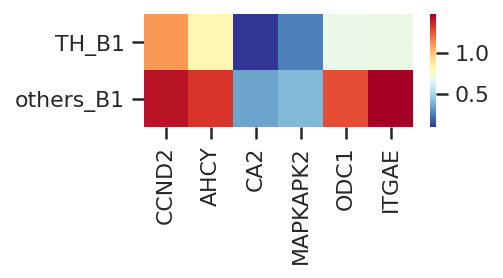

In [118]:
fig, ax = plt.subplots(figsize=(df5.shape[1]/2,df5.shape[0]/2))
sb.heatmap(df5,cmap='RdYlBu_r')
plt.savefig(fig_path+'THvsothersB1_neglfc_heatmap.pdf',bbox_inches='tight');

# BM vs other organ CCR2 monocytes

## GSEA plot for significant DGEs

In [19]:
### load DGE results
dge = pd.read_csv(DGE_path+'DE_results_BM_vs_rest_TEST_MONOCYTE_III_CCR2_CTRL_NK-MID_ERY-MACROPHAGE_II.csv')
test = ["MONOCYTE_III_CCR2"]
ctrl = ["NK","MID_ERY"]

In [20]:
# find background set of genes 
background = list(set(dge['name']))

In [122]:
# for positively enriched list
# find genes that adjusted pval < 0.1, lfc > 1 for at least 3 test cell types
# but not within the significant list (adjusted pval < 0.1, lfc > 0) in control cell type
dge_sig = dge[np.array(dge['adj_pval']<0.1) & np.array(dge['lfc'] > 0)]
dge_sig_test = dge_sig[np.array(dge_sig['test_celltype'].isin(test)) & np.array(dge_sig['lfc'] > 1)]
tbl = pd.DataFrame.from_dict(Counter(dge_sig_test['name']), orient='index').reset_index()

dge_sig_ctl = dge_sig[dge_sig['test_celltype'].isin(ctrl)]
tbl_new = tbl[~(tbl['index'].isin(dge_sig_ctl['name']))]

df = tbl_new
df['lfc_mean'] = 0
for i in range(df.shape[0]):
    gene = df.iloc[i,0]
    df.iloc[i,2] = np.mean(dge_sig_test.loc[dge_sig_test['name']==gene,'lfc'])
df.to_csv('csv/DE_results_CCR2MONO_BMvsOther_compiled_poslfc.csv')

# for negatively enriched list
# find genes that adjusted pval < 0.1, lfc < -1 for at least 3 test cell types
# but not within the significant list (adjusted pval < 0.1, lfc > 0) in control cell type
dge_sig = dge[np.array(dge['adj_pval']<0.1) & np.array(dge['lfc'] < 0)]
dge_sig_test = dge_sig[np.array(dge_sig['test_celltype'].isin(test)) & np.array(dge_sig['lfc'] < -1)]
tbl = pd.DataFrame.from_dict(Counter(dge_sig_test['name']), orient='index').reset_index()

dge_sig_ctl = dge_sig[dge_sig['test_celltype'].isin(ctrl)]
tbl_new = tbl[~(tbl['index'].isin(dge_sig_ctl['name']))]

df = tbl_new
df['lfc_mean'] = 0
for i in range(df.shape[0]):
    gene = df.iloc[i,0]
    df.iloc[i,2] = np.mean(dge_sig_test.loc[dge_sig_test['name']==gene,'lfc'])
df.to_csv('csv/DE_results_CCR2MONO_BMvsOther_compiled_neglfc.csv')

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [21]:
df = pd.read_csv('csv/DE_results_CCR2MONO_BMvsOther_compiled_neglfc.csv')
gene_list = list(df['index'])

In [22]:
gene_sets=['MSigDB_Hallmark_2020']

# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_sets,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 background=background,
                 description='DE_results_CCR2MONO_BMvsOther_compiled_neglfc',
                 outdir='csv/enrichr/',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [23]:
# obj.results stores all results
enr.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,7/200,0.000047,0.001703,0,0,8.124352,80.909869,IL1B;PLAUR;TRIP10;G0S2;HES1;SOD2;PNRC1
1,MSigDB_Hallmark_2020,KRAS Signaling Up,6/200,0.000385,0.006934,0,0,6.849647,53.849903,MAFB;TSPAN13;IL1B;C3AR1;PLAUR;G0S2
2,MSigDB_Hallmark_2020,Pperoxisome,4/104,0.001528,0.018340,0,0,8.705495,56.442952,ACSL1;BCL10;SOD2;DHRS3
3,MSigDB_Hallmark_2020,Inflammatory Response,5/200,0.002662,0.023961,0,0,5.615385,33.291011,IL1R1;IL1B;OSM;C3AR1;PLAUR
4,MSigDB_Hallmark_2020,Cholesterol Homeostasis,3/74,0.005275,0.037977,0,0,9.109308,47.776950,PLAUR;CPEB2;PNRC1


In [24]:
# to save your figure, make sure that ``ofname`` is not None
ax=dotplot(enr.res2d, title='MSigDB_Hallmark_2020',cmap='RdYlBu_r',cutoff = 1,top_terms=5,figsize=(6,6),ofname=fig_path+'BMvsothersCCR2MONO_neglfc_enrichr.pdf')

## Plot significant DGEs in organ comparison 

In [25]:
enr.results.iloc[0,]

Gene_set                                  MSigDB_Hallmark_2020
Term                             TNF-alpha Signaling via NF-kB
Overlap                                                  7/200
P-value                                            4.73032e-05
Adjusted P-value                                    0.00170292
Old P-value                                                  0
Old Adjusted P-value                                         0
Odds Ratio                                             8.12435
Combined Score                                         80.9099
Genes                   IL1B;PLAUR;TRIP10;G0S2;HES1;SOD2;PNRC1
Name: 0, dtype: object

In [26]:
genes = enr.results.iloc[0,9].split(';') 

In [129]:
ct_data = adata[adata.obs['anno_lvl_2_final_clean']=='MONOCYTE_II_CCR2']

In [130]:
donor_organ_list = set(ct_data.obs['donor_organ'])
df = pd.DataFrame(index = range(len(donor_organ_list) * len(genes)), columns = ['donor_organ','donor','organ','expression','gene'])
df['donor_organ']=list(donor_organ_list)*len(genes)
df['genes']=np.repeat(np.array(genes),len(donor_organ_list))
for i in df.index: 
    donor_organ = df['donor_organ'][i]
    data_select = ct_data[ct_data.obs['donor_organ']==donor_organ]
    gene = df['genes'][i]
    df.iloc[i,3]=np.mean(data_select[:,gene].X)
df['donor']=[name.split('_')[0] for name in df['donor_organ']]
df['organ']=[name.split('_')[1] for name in df['donor_organ']]
df['organ']=df['organ'].astype('category')
df['organ']=df['organ'].cat.reorder_categories([organ for organ in organ_order if organ in set(df['organ'])])

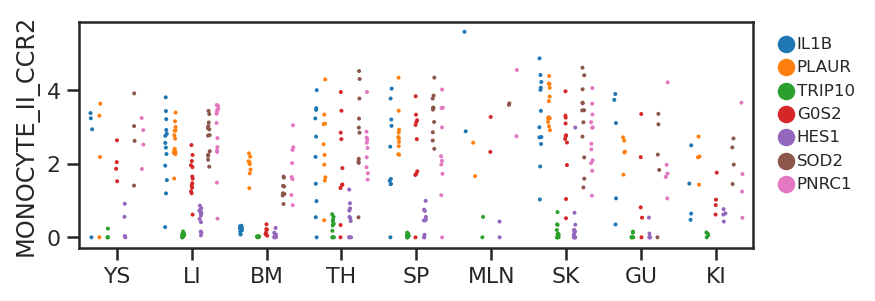

In [148]:
#plt.rcParams["figure.figsize"] = [8,8]
sb.set_theme(style='ticks')
fig, ax = plt.subplots(figsize=(6,2))
s = sb.stripplot(x="organ", y="expression",hue='genes',data=df, palette="tab10",dodge=True,size=2)
s.set(ylabel='MONOCYTE_II_CCR2')
s.set(xlabel='')
ax.legend(loc='upper left',bbox_to_anchor=(1.02, 1),frameon=False, fontsize='x-small')
#plt.savefig(fig_path+'CCR2MONO_poslfc_stripplot.pdf',bbox_inches='tight')

combine poslfc and neglfc for dotplot and use adata_scale 

In [131]:
df4 = pd.DataFrame(index = range(2), columns=['organ','ct']+genes)
df4['organ']=['BM','others']
df4['ct']=['MONOCYTE_II_CCR2']*2
for i in df4.index:
    ct = df4['ct'][i]
    
    if df4['organ'][i]=='BM':
        a = np.array(adata.obs['organ'].isin(['BM']))
        b = np.array(adata.obs['anno_lvl_2_final_clean']==ct)
        data_select=adata[list(a&b)]
        
        for gene in genes:
            df4[gene][i] = np.mean(data_select[:,gene].X)
    else:
        a = np.array(~(adata.obs['organ'].isin(['BM'])))
        b = np.array(adata.obs['anno_lvl_2_final_clean']==ct)
        data_select=adata[list(a&b)]
        
        for gene in genes:
            df4[gene][i] = np.mean(data_select[:,gene].X)
df5 = df4.iloc[:,2:].astype('float')
df5.index=df4['organ']+'_'+df4['ct']

In [135]:
df5

,IL1B,PLAUR,TRIP10,G0S2,HES1,SOD2,PNRC1
BM_MONOCYTE_II_CCR2,0.202509,2.019902,0.016436,0.129839,0.038715,1.366692,2.070132
others_MONOCYTE_II_CCR2,2.346334,2.772235,0.075872,2.018334,0.436086,3.036828,2.541528


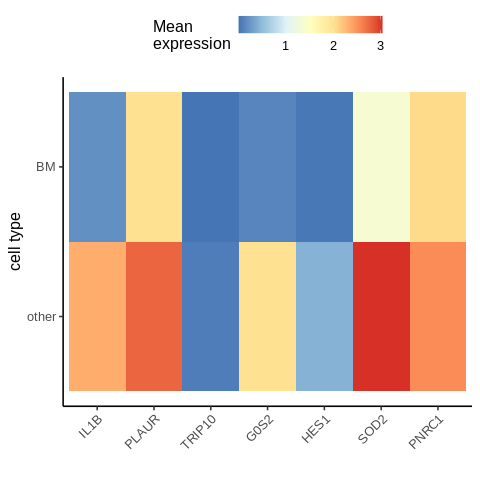

In [139]:
%%R -i df5 -i genes -i fig_path
gene_set_name = ""
ct_order=c('MONOCYTE_II_CCR2')

pl2 <- rownames_to_column(df5) %>%
        pivot_longer(cols=-rowname, names_to="gene", values_to="expression") %>%
        mutate(organ=ifelse(str_detect(rowname, '^BM'), "BM", "other"),
               celltype=str_remove(rowname, 'BM_|others_')
              ) %>%
        mutate(organ=factor(organ, levels=rev(c("BM", "other")))) %>%
        mutate(gene=factor(gene, levels=genes)) %>%
        mutate(celltype=factor(celltype, levels=rev(ct_order))) %>%
        ggplot(aes(gene, organ, fill=expression)) +
        geom_tile() +
        scale_fill_distiller(palette='RdYlBu', name='Mean\nexpression') +
        guides(fill=guide_colorbar(barwidth = 10)) +
        ylab("cell type") + 
        xlab(gene_set_name) +
        theme_classic(base_size=16) +
        theme(axis.text.x=element_text(angle=45, hjust=1),
             legend.position='top') 
        
pl2 + ggsave(paste0(fig_path, 'CCR2MONO_neglfc_heatmap.clean.pdf'), width=4, height=3) 

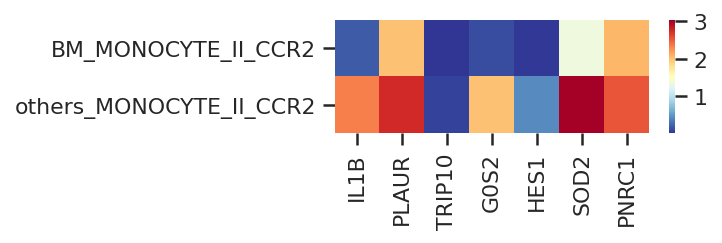

In [150]:
# fig, ax = plt.subplots(figsize=(df5.shape[1]/2,df5.shape[0]/2))
# sb.heatmap(df5,cmap='RdYlBu_r')
# plt.savefig(fig_path+'CCR2MONO_neglfc_heatmap.pdf',bbox_inches='tight');

In [140]:
df = pd.read_csv('csv/DE_results_CCR2MONO_BMvsOther_compiled_poslfc.csv')
gene_list = list(df['index'])

In [141]:
gene_sets=['MSigDB_Hallmark_2020']

In [142]:
# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_sets,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 background=background,
                 description='test_name',
                 outdir='csv/enrichr/',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [143]:
# obj.results stores all results
enr.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,G2-M Checkpoint,11/200,1.444966e-07,0.000002,0,0,9.015665,141.996810,CDC20;TOP2A;GINS2;CCNB2;UCK2;CENPF;DTYMK;NSD2;...
1,MSigDB_Hallmark_2020,E2F Targets,11/200,1.444966e-07,0.000002,0,0,9.015665,141.996810,CDC20;TOP2A;CCNB2;HELLS;LIG1;MCM7;UBE2T;CTPS1;...
2,MSigDB_Hallmark_2020,Pperoxisome,4/104,5.859217e-03,0.056639,0,0,5.899104,30.319860,TOP2A;PEX6;DHCR24;CTPS1
3,MSigDB_Hallmark_2020,Estrogen Response Late,5/200,1.264672e-02,0.061126,0,0,3.791594,16.570621,CDC20;TOP2A;GINS2;MYB;SLC1A4
4,MSigDB_Hallmark_2020,mTORC1 Signaling,5/200,1.264672e-02,0.061126,0,0,3.791594,16.570621,SLC1A4;DHCR24;PHGDH;RRP9;MCM2


In [127]:
# to save your figure, make sure that ``ofname`` is not None
ax=dotplot(enr.res2d, title='MSigDB_Hallmark_2020',cmap='RdYlBu_r',cutoff = 1,top_terms=5,figsize=(6,6),ofname=fig_path+'BMvsothersCCR2MONO_neglfc_enrichr.pdf')

## Plot significant DGEs in organ comparison 

In [149]:
genes = enr.results.iloc[0,9].split(';') 

In [151]:
ct_data = adata[adata.obs['anno_lvl_2_final_clean']=='MONOCYTE_II_CCR2']

In [152]:
donor_organ_list = set(ct_data.obs['donor_organ'])
df = pd.DataFrame(index = range(len(donor_organ_list) * len(genes)), columns = ['donor_organ','donor','organ','expression','gene'])
df['donor_organ']=list(donor_organ_list)*len(genes)
df['genes']=np.repeat(np.array(genes),len(donor_organ_list))
for i in df.index: 
    donor_organ = df['donor_organ'][i]
    data_select = ct_data[ct_data.obs['donor_organ']==donor_organ]
    gene = df['genes'][i]
    df.iloc[i,3]=np.mean(data_select[:,gene].X)
df['donor']=[name.split('_')[0] for name in df['donor_organ']]
df['organ']=[name.split('_')[1] for name in df['donor_organ']]
df['organ']=df['organ'].astype('category')
df['organ']=df['organ'].cat.reorder_categories([organ for organ in organ_order if organ in set(df['organ'])])

In [153]:
# #plt.rcParams["figure.figsize"] = [8,8]
# sb.set_theme(style='ticks')
# fig, ax = plt.subplots(figsize=(6,2))
# s = sb.stripplot(x="organ", y="expression",hue='genes',data=df, palette="tab10",dodge=True,size=2)
# s.set(ylabel='MONOCYTE_II_CCR2')
# s.set(xlabel='')
# ax.legend(loc='upper left',bbox_to_anchor=(1.02, 1),frameon=False, fontsize='x-small')
# #plt.savefig(fig_path+'CCR2MONO_poslfc_stripplot.pdf',bbox_inches='tight')

combine poslfc and neglfc for dotplot and use adata_scale 

In [154]:
df4 = pd.DataFrame(index = range(2), columns=['organ','ct']+genes)
df4['organ']=['BM','others']
df4['ct']=['MONOCYTE_II_CCR2']*2
for i in df4.index:
    ct = df4['ct'][i]
    
    if df4['organ'][i]=='BM':
        a = np.array(adata.obs['organ'].isin(['BM']))
        b = np.array(adata.obs['anno_lvl_2_final_clean']==ct)
        data_select=adata[list(a&b)]
        
        for gene in genes:
            df4[gene][i] = np.mean(data_select[:,gene].X)
    else:
        a = np.array(~(adata.obs['organ'].isin(['BM'])))
        b = np.array(adata.obs['anno_lvl_2_final_clean']==ct)
        data_select=adata[list(a&b)]
        
        for gene in genes:
            df4[gene][i] = np.mean(data_select[:,gene].X)
df5 = df4.iloc[:,2:].astype('float')
df5.index=df4['organ']+'_'+df4['ct']

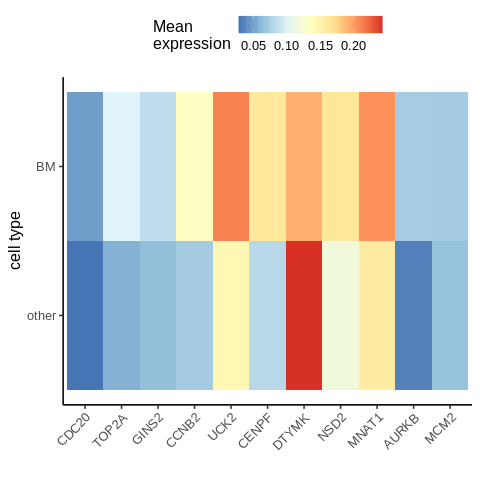

In [155]:
%%R -i df5 -i genes -i fig_path
gene_set_name = ""
ct_order=c('MONOCYTE_II_CCR2')

pl <- rownames_to_column(df5) %>%
        pivot_longer(cols=-rowname, names_to="gene", values_to="expression") %>%
        mutate(organ=ifelse(str_detect(rowname, '^BM'), "BM", "other"),
               celltype=str_remove(rowname, 'BM_|others_')
              ) %>%
        mutate(organ=factor(organ, levels=rev(c("BM", "other")))) %>%
        mutate(gene=factor(gene, levels=genes)) %>%
        mutate(celltype=factor(celltype, levels=rev(ct_order))) %>%
        ggplot(aes(gene, organ, fill=expression)) +
        geom_tile() +
        scale_fill_distiller(palette='RdYlBu', name='Mean\nexpression') +
        guides(fill=guide_colorbar(barwidth = 10)) +
        ylab("cell type") + 
        xlab(gene_set_name) +
        theme_classic(base_size=16) +
        theme(axis.text.x=element_text(angle=45, hjust=1),
             legend.position='top') 
        
pl + ggsave(paste0(fig_path, 'CCR2MONO_poslfc_heatmap.clean.pdf'), width=4, height=3) 

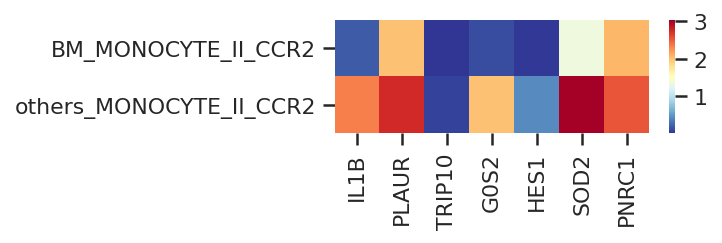

In [150]:
# fig, ax = plt.subplots(figsize=(df5.shape[1]/2,df5.shape[0]/2))
# sb.heatmap(df5,cmap='RdYlBu_r')
# plt.savefig(fig_path+'CCR2MONO_neglfc_heatmap.pdf',bbox_inches='tight');

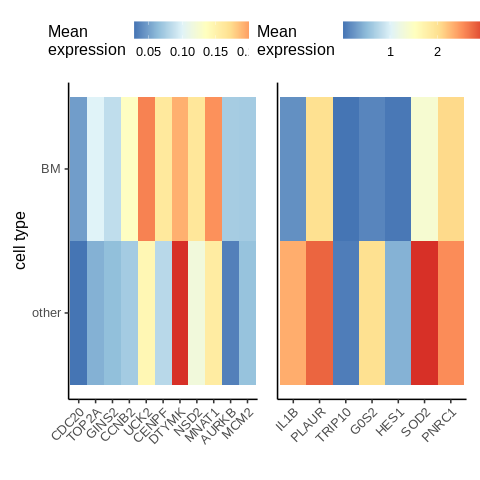

In [158]:
%%R
(pl | (pl2 + remove_y_axis())) +
    ggsave('~/mount/gdrive/Pan_fetal/writing/ms_figures/draft_panels/Fig2_myeloid_lymphoid/assemble_fig2/CCR2MONO_heatmap.clean.pdf', 
           width=8, height=3) 